In [14]:
import sys
import regions
import pyavm
import numpy as np
import PIL

from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.visualization import simple_norm

import reproject 
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from astropy.table import Table
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u

from reproject import reproject_interp

from spectral_cube import SpectralCube
from spectral_cube import Projection

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils import background

import regions
import cv2

import warnings

from astropy.visualization.wcsaxes import add_scalebar
from astropy.visualization.wcsaxes import add_beam

In [2]:
ls -l /orange/adamginsburg/jwst/cloudc/F405N/*basic*

-rw-rw-r--+ 1 savannahgramze adamginsburg 39772800 May 26 05:16 /orange/adamginsburg/jwst/cloudc/F405N/f405n_merged-reproject_daophot_basic.fits
-rw-rw-r--+ 1 savannahgramze adamginsburg 38252160 Jul  2 18:06 /orange/adamginsburg/jwst/cloudc/F405N/f405n_merged_bgsub_blur_daophot_basic.fits
-rw-rw-r--+ 1 savannahgramze adamginsburg 38229120 Jul  2 18:25 /orange/adamginsburg/jwst/cloudc/F405N/f405n_merged_blur_daophot_basic.fits
-rw-rw-r--+ 1 savannahgramze adamginsburg 48683520 May 31 16:02 /orange/adamginsburg/jwst/cloudc/F405N/f405n_merged_daophot_basic.fits
-rw-rw-r--+ 1 savannahgramze adamginsburg 28451520 May 31 13:30 /orange/adamginsburg/jwst/cloudc/F405N/f405n_nrca_daophot_basic.fits
-rw-rw-r--+ 1 savannahgramze adamginsburg 31069440 May 25 08:18 /orange/adamginsburg/jwst/cloudc/F405N/f405n_nrcb_daophot_basic.fits


In [3]:
cat_noblur = Table.read('/orange/adamginsburg/jwst/cloudc/F405N/f405n_merged_daophot_basic.fits')
cat_blur = Table.read('/orange/adamginsburg/jwst/cloudc/F405N/f405n_merged_blur_daophot_basic.fits')
cat_blur_bgsub = Table.read('/orange/adamginsburg/jwst/cloudc/F405N/f405n_merged_bgsub_blur_daophot_basic.fits')

In [4]:
cat_blur[:2]

id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,qfit,cfit,flags,skycoord_centroid
,,,,,,,,,,,,,,,,,"deg,deg"
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,SkyCoord
1,1,1,11.51058292388916,1611.4612764340154,5.769610990267128,836.3684386473363,1611.7492481619831,7.110714081953389,192.3894529839983,--,--,--,25,0.5737105191274551,-0.01071234041090682,8,"266.6162737502179,-28.548936525295897"
2,2,1,12.777621746063232,1627.9400098494737,4.950018403862148,488.2869039875046,1627.9647538671347,4.987895750970715,1.721972759728651,34.23610801865304,34.419724430451936,36.90378412483525,25,69.97458960583555,2.826767454210777,0,"266.61628550105917,-28.549222423415934"


In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
#from astropy.matching import catalog_matching

# Get the SkyCoord objects from the tables
coords_blur = SkyCoord(cat_blur['skycoord_centroid'])
coords_blur_bgsub = SkyCoord(cat_blur_bgsub['skycoord_centroid'])

matches, sep, _ = coords_blur.match_to_catalog_sky(coords_blur_bgsub, nthneighbor=1)

mask = sep > 0.3*u.arcsec

newcrds = coords_blur[sep > 0.3*u.arcsec]
basecrds = SkyCoord([coords_blur_bgsub, newcrds])

In [6]:
from astropy import table

In [7]:
basetable = Table()
basetable['skycoord_ref'] = basecrds

In [8]:
matches, sep, _ = basecrds.match_to_catalog_sky(coords_blur, nthneighbor=1)

cat_blur_copy = cat_blur[matches]

cat_blur_copy.add_column(name="sep", col=sep)

for col in cat_blur_copy.colnames:
    if 'skycoord' in col:
        cat_blur_copy.remove_column(col)
    else:
        cat_blur_copy[col].name = col + '_blur'
#stack_blur = hstack([cat_blur_copy, coords_blur])
basetable = table.hstack([basetable, cat_blur_copy], join_type='exact')

In [9]:
matches, sep, _ = basecrds.match_to_catalog_sky(coords_blur_bgsub, nthneighbor=1)

cat_blur_bgsub_copy = cat_blur_bgsub[matches]#cat_blur_bgsub.copy()

cat_blur_bgsub_copy.add_column(name="sep", col=sep)

for col in cat_blur_bgsub_copy.colnames:
    if 'skycoord' in col:
        cat_blur_bgsub_copy.remove_column(col)
    else:
        cat_blur_bgsub_copy[col].name = col + '_blur_bgsub'
#stack_blur_bgsub = hstack([cat_blur_bgsub_copy, coords_blur_bgsub])
basetable = table.hstack([basetable, cat_blur_bgsub_copy], join_type='exact')

In [10]:
basetable[:2]

skycoord_ref,id_blur,group_id_blur,group_size_blur,local_bkg_blur,x_init_blur,y_init_blur,flux_init_blur,x_fit_blur,y_fit_blur,flux_fit_blur,x_err_blur,y_err_blur,flux_err_blur,npixfit_blur,qfit_blur,cfit_blur,flags_blur,sep_blur,id_blur_bgsub,group_id_blur_bgsub,group_size_blur_bgsub,local_bkg_blur_bgsub,x_init_blur_bgsub,y_init_blur_bgsub,flux_init_blur_bgsub,x_fit_blur_bgsub,y_fit_blur_bgsub,flux_fit_blur_bgsub,x_err_blur_bgsub,y_err_blur_bgsub,flux_err_blur_bgsub,npixfit_blur_bgsub,qfit_blur_bgsub,cfit_blur_bgsub,flags_blur_bgsub,sep_blur_bgsub
"deg,deg",,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,deg
SkyCoord,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64
"266.6162807867614,-28.54894803328616",1,1,1,11.51058292388916,1611.4612764340154,5.769610990267128,836.3684386473363,1611.7492481619831,7.110714081953389,192.3894529839983,--,--,--,25,0.5737105191274551,-0.01071234041090682,8,1.3062854322713635e-05,1,1,1,0.311320960521698,1611.449454384178,4.786180021848157,290.85963862599374,1612.3709930015577,6.697143137048334,185.95198394131396,0.2689687716003722,0.28296810227705566,28.84839176276231,25,0.43331807690669716,0.03152834333905832,0,0.0
"266.61629825569185,-28.5492229993423",2,2,1,12.777621746063232,1627.9400098494737,4.950018403862148,488.2869039875046,1627.9647538671347,4.987895750970715,1.721972759728651,34.23610801865304,34.419724430451936,36.90378412483525,25,69.97458960583555,2.826767454210777,0,1.121854977837546e-05,2,2,1,1.9432668685913086,1627.9624562169658,4.505885835419517,53.55603790008783,1627.9373625299431,4.34717843605125,35.05216358784127,0.7375478268085728,0.7349227227513478,16.176743595605544,25,1.7419316944169019,0.07739773144758741,0,0.0


In [11]:
import numpy as np

# Create a mask for rows with sep > 0.3 arcsec
mask = np.logical_or(basetable['sep_blur'] > 0.3, basetable['sep_blur_bgsub'] > 0.3)

# Remove columns with the mask
basetable = basetable[~mask]

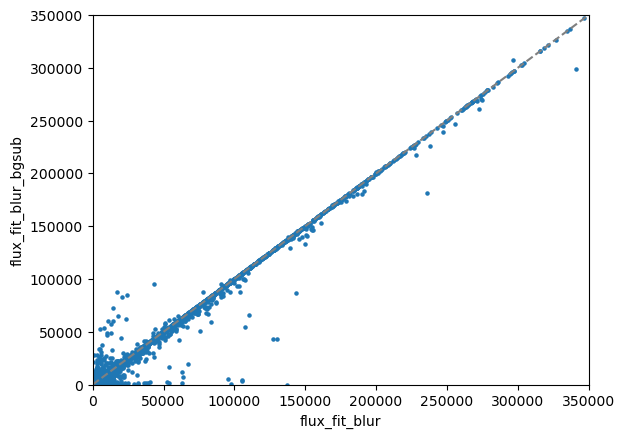

In [12]:
plt.scatter(x=basetable['flux_fit_blur'], y=basetable['flux_fit_blur_bgsub'], s=5, marker='o')

x = [1, 700000]
y = [1, 700000]
plt.plot(x, y, linestyle='--', color='grey')

plt.xlabel('flux_fit_blur')
plt.ylabel('flux_fit_blur_bgsub')

plt.xlim(0, 350000)
plt.ylim(0, 350000)

plt.show()


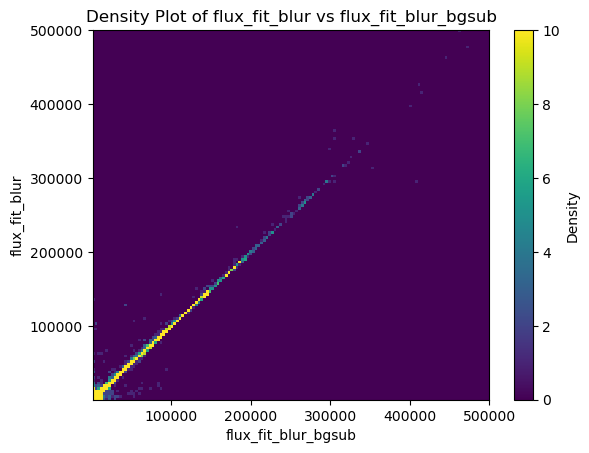

In [13]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

# Extract the flux_fit_blur and flux_fit_blur_bgsub columns from the table
flux_fit_blur = basetable['flux_fit_blur']
flux_fit_blur_bgsub = basetable['flux_fit_blur_bgsub']

# Create a density plot
plt.hist2d(flux_fit_blur_bgsub, flux_fit_blur, bins=200, cmap='viridis', vmin=0, vmax=10)
plt.colorbar(label='Density')
#plt.plot(x, y, linestyle='--', color='grey')
plt.xlabel('flux_fit_blur_bgsub')
plt.ylabel('flux_fit_blur')
plt.title('Density Plot of flux_fit_blur vs flux_fit_blur_bgsub')
plt.xlim(1000, 500000)
plt.ylim(1000, 500000)
plt.show()

In [15]:
cat_blur_bgsub.columns

<TableColumns names=('id','group_id','group_size','local_bkg','x_init','y_init','flux_init','x_fit','y_fit','flux_fit','x_err','y_err','flux_err','npixfit','qfit','cfit','flags','skycoord_centroid')>

In [16]:
qf = cat_blur_bgsub['qfit']
flux = cat_blur_bgsub['flux_fit']

(0.0, 1.0)

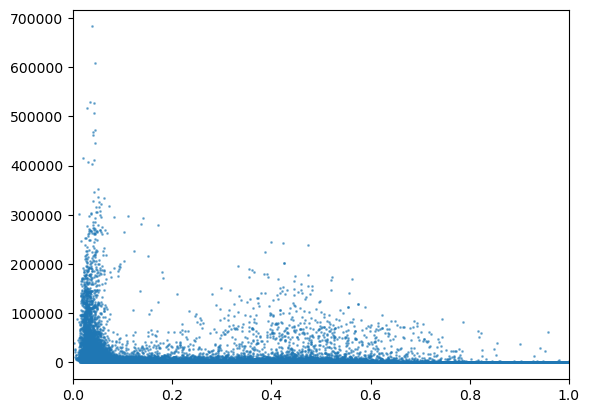

In [19]:
plt.scatter(qf, flux, s=1, alpha=0.5)
plt.xlim(left=0, right=1)